# <font size="6"><b>Assignment V: GitHub and the ticketmaster.com API (Python)</b></font>
<font size="5">Data Science Project Management (DS400) | Winter Term 2022/23</font>

<br>

<div class="author_year">
Submitted by Jakob Zgonc (6293178)<br>
Submitted on 30.01.2023
</div>

<br>

---

<h2>Table of Contents<span class="tocSkip"></span></h2>

<div class="toc">
    <ul class="toc-item", style="list-style-type:none;">
        <li><span><a href="#1-Interacting-with-the-API---the-basics">1 Interacting with the API - the basics</a></span></li>
        <li><span><a href="#2-Interacting-with-the-API---advanced">2 Interacting with the API - advanced</a></span></li>
        <li><span><a href="#3-Visualizing-the-extracted-data">3 Visualizing the extracted data</a></span></li>
        <li><span><a href="#4-Event-locations-in-other-countries">4 Event locations in other countries</a></span></li>
    </ul>
</div>

<br>

---

**Code of conduct**

*I hereby acknowledge that the submitted assignment is my own work. During the preparation of this assignment I have worked together with Max Mohr and Felix Koehn.*

<br>

---

In [1]:
%%html
<style>

div.author_year {
    color: #708090;
    font-size: 17px;
    font-style: italic;
}

div.task {
    background-color:#DAE3F3;
    color: #337AB7; /*  #002060;*/
    border-radius: 10px; 
    padding: 20px;
    margin-top: 20px;
    margin-bottom: 20px;
    margin-left: -5px;
    margin-right: -20px;
    font-size: 15px;
    border-left: 10px solid #337AB7;
}

body {
    max-width:960px;
    margin:0 auto;
}

</style>

This document is also available in [this GitHub repository](https://github.com/jzgonc/dspm_2022_assignment_5).

---

## 1 Interacting with the API - the basics

<div class="task">
    <ol start=7>
        <li>Perform a first <code>GET</code> request, that searches for event venues in Germany (<code>countryCode = "DE"</code>). Extract the content from the response object and inspect the resulting list. Describe what you can see.
        </li>
        </ol>
</div>

In [2]:
# import packages
import time
import requests
import numpy as np
import pandas as pd
import pprint
import geopandas as gpd
import matplotlib.pyplot as plt

In [3]:
# get API key
with open('ticketmaster_api_key.txt','r') as file:
    apikey = file.read()

In [4]:
# url for venues
url = 'https://app.ticketmaster.com/discovery/v2/venues'

In [5]:
# define params for API call
params = dict(apikey=apikey, countryCode='DE', locale='*')

# get response from API call as json (i.e. dictionary)
venues_DE_first_page = requests.get(url=url, params=params).json()

# show response
pprint.pprint(venues_DE_first_page)

{'_embedded': {'venues': [{'_links': {'self': {'href': '/discovery/v2/venues/KovZpZAn6vEA?locale=en-de'}},
                           'ada': {'adaCustomCopy': 'Sollten Sie besondere '
                                                    'Sitzplatzwünsche haben, '
                                                    'prüfen Sie bitte die '
                                                    'Informationsseite des '
                                                    'Veranstaltungsortes. Für '
                                                    'weitergehende '
                                                    'Informationen steht Ihnen '
                                                    'unsere Hotline unter '
                                                    '+49.(0)1805 - 969 0000 '
                                                    '(14 Ct./Min.) zur '
                                                    'Verfügung.',
                                   'adaHours': 'Montag bis Fr

The response of the API call is a nested dictionary (not a list as stated in the task, but that's probably the R wording). On the first level there are three items:
* `_embedded` contains the actual data we have requested. The value is a dictionary itself. In this dictionary, again, there is a list with all returned venues (each of which is a dictionary, again)
* `_links` contains the url that was used for the API call (excluding the apikey and the domain). In addition, it contains the urls for the first, next and last page.
* `page` contains information about the returned page from the data source

<div class="task">
    <ol start=8>
        <li>Extract the <code>name</code>, the <code>city</code>, the <code>postalCode</code> and <code>address</code>, as well as the <code>url</code> and the <code>longitude</code> and <code>latitude</code> of the <code>venues</code> to a data frame. This data frame should have the following structure:
        <br><br>
<code>## Rows: 20
## Columns: 7
## $ name       chr "Gruenspan", "Huxleys Neue Welt", "Kleine Olympiahalle", "Z~
## $ city       chr "Hamburg", "Berlin", "Munich", "Emmelshausen", "Mülheim", "~
## $ postalCode dbl 22767, 10967, 80809, 56281, 45479, 76646, 68766, 44263, 542~
## $ address    chr "Grosse Freiheit 58", "Hasenheide 107 – 113", "Spiridon-Lou~
## $ url        chr "http://www.ticketmaster.de/venue/287155", "http://www.tick~
## $ longitude  dbl 9.958075, 13.421380, 11.550920, 7.556560, 6.874710, 8.59908~
## $ latitude   dbl 53.55188, 52.48639, 48.17543, 50.15544, 51.42778, 49.12692,~</code></li>
</ol>
</div>

In [6]:
def retrieve_from_dict(d: dict, first_level: str, second_level: str = None):
    """Retrieve a value from a dictionary. The value might be on the second
    level of the dictionary. If the specified key does not exist in the
    dictionary, None will be returned.
    
    Args:
    -----
    d: dictionary
        dictionary to retrieve the value from
        
    first_level: string
        key for the dictionary item
        
    second_level: string
        key for the dictionary on the second level, i.e. if the first level
        value was a dictionary itself
        
    Returns:
    --------
    value:
        retrieved value
    
    """
  
    # retrieve first level, if key does not exist in d -> set value to None
    value = d.get(first_level, None)

    # retrieve second level, but only if first level key existed
    # if key does not exist in d -> set value to None
    if (value is not None) and (second_level is not None):
        value = value.get(second_level, None)
    
    return value

In [7]:
def create_df(venue: dict) -> pd.DataFrame:
    """Create a dataframe from a dictionary for a single venue.
    
    Args:
    -----
    venue: dictionary
        dictionary that contains the response from the API call for a single
        venue
        
    Returns:
    --------
    venue_simplified_df: pandas DataFrame
        dataframe with simplified information for a single venue retrieved from
        the input dictionary
        
    """
      
    # simplify venue dictionary by extracting relevant information
    venue_simplified = dict(
        name=retrieve_from_dict(venue, 'name'),
        city=retrieve_from_dict(venue, 'city', 'name'),
        postalCode=retrieve_from_dict(venue, 'postalCode'),
        address=retrieve_from_dict(venue, 'address', 'line1'),
        url=retrieve_from_dict(venue, 'url'),
        longitude=retrieve_from_dict(venue, 'location', 'longitude'),
        latitude=retrieve_from_dict(venue, 'location', 'latitude')
    )

    # convert to pandas data frame (the index is needed as its only one row)
    venue_simplified_df = pd.DataFrame(venue_simplified, index=[0])

    return venue_simplified_df

In [8]:
def get_venues_df_single_page(venues: list[dict]) -> pd.DataFrame:
    """Create a data frame of all venues from a single page. Every venue builds
    a row.
    
    Args:
    -----
    venues: list of dictionaries
        list that contains a dictionary for every venue
    
    Returns:
    --------
    venues_df_single_page: pandas DataFrame
        data frame that contains information for all venues from a single page
    
    """
      
    # call create_df function for each dictionary in venues list
    # and concatenate to a single data frame
    venues_df_single_page = pd.concat(
        [create_df(venue) for venue in venues]
    ).reset_index(drop=True)

    return venues_df_single_page

In [9]:
# call function to get information of all venues on the first page in a data frame
get_venues_df_single_page(venues = venues_DE_first_page['_embedded']['venues'])

,name,city,postalCode,address,url,longitude,latitude
0,Grosse Freiheit 36,Hamburg,22767,Grosse Freiheit 36,http://www.ticketmaster.de/venue/287636,9.957905,53.551187
1,Gruenspan,Hamburg,22767,Grosse Freiheit 58,http://www.ticketmaster.de/venue/287155,9.958075,53.551885
2,Huxleys Neue Welt,Berlin,10967,Hasenheide 107 – 113,http://www.ticketmaster.de/venue/286842,13.42138,52.486391
3,Zentrum am Park,Emmelshausen,56281,Rhein-Mosel-Straße 45,https://www.ticketmaster.de/venue/zentrum-am-p...,7.55656,50.15544
4,Stadthalle (Theatersaal),Mülheim,45479,Theodor-Heuss-Platz 1,https://www.ticketmaster.de/venue/stadthalle-t...,6.87471,51.42778
5,Schlossgarten,Bruchsal,76646,Schloss Bruchsal,https://www.ticketmaster.de/venue/schlossgarte...,8.59908,49.12692
6,Stadthalle,Hockenheim,68766,Rathausstraße 3,https://www.ticketmaster.de/venue/stadthalle-h...,8.54908,49.31849
7,FZW,Dortmund,44263,Ritterstraße 20,https://www.ticketmaster.de/venue/fzw-dortmund...,7.4501,51.51481
8,Arena Trier,Trier,54292,Fort-Worth-Platz 1,https://www.ticketmaster.de/venue/arena-trier-...,6.66426,49.77183
9,Eissporthalle,Memmingen,87700,Hühnerbergstraße 19,https://www.ticketmaster.de/venue/eissporthall...,10.16293,47.97999


## 2 Interacting with the API - advanced

<div class="task">
    <ol start=9>
        <li>Have a closer look at the list element named <code>page</code>. Did your <code>GET</code> request from exercise (7) return <i>all</i> event locations in Germany? Obviously not - there are of course much more venues in Germany than those contained in this list. Your <code>GET</code> request only yielded the first results page containing the first 20 out of several thousands of venues. Check the API documentation under the section <a href="https://developer.ticketmaster.com/products-and-docs/apis/discovery-api/v2/#search-venues-v2">Venue Search</a>. How can you request the venues from the remaining results pages? Iterate over the results pages and perform <code>GET</code> requests for all venues in Germany. After each iteration, extract the seven variables <code>name</code>, <code>city</code>, <code>postalCode</code>, <code>address</code>, <code>url</code>, <code>longitude</code>, and <code>latitude</code>. Join the information in one large data frame. Print the first 10 rows and the shape of the resulting data frame. The resulting data frame should look something like this (note that the exact number of search results may have changed since this document has been last modified):<br><br>
<code>## Rows: 12,671
## Columns: 7
## $ name       chr "Gruenspan", "Huxleys Neue Welt", "Kleine Olympiahalle", "Z~
## $ city       chr "Hamburg", "Berlin", "Munich", "Emmelshausen", "Mülheim", "~
## $ postalCode dbl 22767, 10967, 80809, 56281, 45479, 76646, 68766, 44263, 542~
## $ address    chr "Grosse Freiheit 58", "Hasenheide 107 – 113", "Spiridon-Lou~
## $ url        chr "http://www.ticketmaster.de/venue/287155", "http://www.tick~
## $ longitude  dbl 9.958075, 13.421380, 11.550920, 7.556560, 6.874710, 8.59908~
## $ latitude   dbl 53.55188, 52.48639, 48.17543, 50.15544, 51.42778, 49.12692,~</code></li>
</ol>
</div>

In [10]:
def get_venues_in_country(country_code: str, verbose: bool = True) -> pd.DataFrame:
    """Get all venues from ticketmaster via its API and convert the response
    to a data frame that contains a row for each venue.
    
    Note: This functions uses the global variables 'apikey' and 'url'.
    In order to make this function work properly, these have to be defined.
    
    Args:
    -----
    country_code: string
        country code to be used as parameter for the API call
        
    verbose: boolean
        whether to print status messages to console
        
    Returns:
    --------
    all_venues_df: pandas DataFrame
        data frame that contains the information on all venues in the country
    
    """
    
    # define params for API calls (size parameter can be 500 max)
    params = dict(
        apikey=apikey, 
        countryCode=country_code, 
        locale='*', 
        size=500
    )

    # first API call to get number of pages
    n_pages = (
        requests
        .get(url=url, params=params)
        .json()
        .get('page')
        .get('totalPages')
    )

    # save timestamp of when API call was completed
    time_last_apicall = time.time()

    # create empty list to store single page data frames in
    single_page_dfs = []

    # print message
    if verbose:
        print(f'Starting to retrieve venues in country "{country_code}"'
              f' from {n_pages} pages...')

    # loop through pages
    for page in range(n_pages):

        # add page number to params dictionary
        params['page'] = page

        # make sure we do not more than 5 requests per second
        time_since_last_apicall = time.time() - time_last_apicall
        time.sleep(max(0, 1/5 - time_since_last_apicall))

        # get venues list from API call response
        venues = (
            requests
            .get(url=url, params=params)
            .json()
            .get('_embedded')
            .get('venues')
        )

        # update timestamp of when API call was completed
        time_last_apicall = time.time()

        # get data frame of all venues on the current page
        # and append to single_page_dfs list
        single_page_dfs.append(get_venues_df_single_page(venues=venues))

        # print message (progress)
        fraction = (page+1)/n_pages
        bar_length = 20
        blocks = int(fraction * bar_length) * '#'
        padding = int(bar_length - len(blocks)) * ' '
        print(f'Progress: [{blocks}{padding}] {int(fraction*100)}%',
              end=('\n' if fraction == 1 else '\r'))

    # concatenate all data frames in single_page_dfs list
    all_venues_df = pd.concat(single_page_dfs)
    
    # convert longitude and latitude to float (type object before)
    all_venues_df[['longitude', 'latitude']] = (
        all_venues_df[['longitude', 'latitude']]
        .astype(float)
    )

    # print message
    if verbose:
        print(f'Retrieved data for {all_venues_df.shape[0]} venues.')
        
    # final sleep in case a new request is sent directly after executing 
    # this function
    time_since_last_apicall = time.time() - time_last_apicall
    time.sleep(max(0, 1/5 - time_since_last_apicall))

    return all_venues_df

In [11]:
# call function for Germany (country_code='DE')
venues_DE = get_venues_in_country(country_code = 'DE')

Starting to retrieve venues in country "DE" from 26 pages...
Progress: [####################] 100%
Retrieved data for 12934 venues.


In [12]:
# show data frame (first 10 rows only)
venues_DE.head(10)

,name,city,postalCode,address,url,longitude,latitude
0,Grosse Freiheit 36,Hamburg,22767,Grosse Freiheit 36,http://www.ticketmaster.de/venue/287636,9.957905,53.551187
1,Gruenspan,Hamburg,22767,Grosse Freiheit 58,http://www.ticketmaster.de/venue/287155,9.958075,53.551885
2,Huxleys Neue Welt,Berlin,10967,Hasenheide 107 – 113,http://www.ticketmaster.de/venue/286842,13.421380,52.486391
3,Zentrum am Park,Emmelshausen,56281,Rhein-Mosel-Straße 45,https://www.ticketmaster.de/venue/zentrum-am-p...,7.556560,50.155440
4,Stadthalle (Theatersaal),Mülheim,45479,Theodor-Heuss-Platz 1,https://www.ticketmaster.de/venue/stadthalle-t...,6.874710,51.427780
5,Schlossgarten,Bruchsal,76646,Schloss Bruchsal,https://www.ticketmaster.de/venue/schlossgarte...,8.599080,49.126920
6,Stadthalle,Hockenheim,68766,Rathausstraße 3,https://www.ticketmaster.de/venue/stadthalle-h...,8.549080,49.318490
7,FZW,Dortmund,44263,Ritterstraße 20,https://www.ticketmaster.de/venue/fzw-dortmund...,7.450100,51.514810
8,Arena Trier,Trier,54292,Fort-Worth-Platz 1,https://www.ticketmaster.de/venue/arena-trier-...,6.664260,49.771830
9,Eissporthalle,Memmingen,87700,Hühnerbergstraße 19,https://www.ticketmaster.de/venue/eissporthall...,10.162930,47.979990


In [13]:
# print shape
venues_DE.shape

(12934, 7)

## 3 Visualizing the extracted data

<div class="task">
    <ol start=10>
        <li>Below, you can find code that produces a map of Germany. Add points to the map indicating the locations of the event venues across Germany.</li>
    </ol>
</div>

In [14]:
def plot_venues(
    venues_df: pd.DataFrame,
    country: str,
    lon_lat_ranges: dict = None,
    verbose: bool = True) -> None:
    """Plot venues in a specific country as points on a map.
    
    Args:
    -----
    venues_df: pandas DataFrame
        data frame with the venue data 
        (longitude and latitude have to be numeric)
        
    country: string
        name of the country, needed for retrieving the base map
        
    lon_lat_ranges: dictionary [optional]
        dictionary that contains the ranges for longitude and latitude to clip
        the data, only used if not None
        (default=None)
        
    verbose: boolean [optional]
        whether it should be printed how many venues are not plotted for
        different reasons
        (default=True)
        
    """
    
    # print number of missing values
    if verbose:
    
        # compute number of missing values
        n_NAs = venues_df[['longitude', 'latitude']].isna().any(axis=1).sum()

        # print message
        print(n_NAs, 'venues are not plotted due to missing coordinates.')
    
    # if ranges for longitude and latitude are specified
    if lon_lat_ranges is not None:
        
        # for print message original number of venues is needed
        if verbose:
            n_venues_orig = venues_df.shape[0]
        
        # filter venues by coordinate ranges
        lon_range = lon_lat_ranges["longitude"]
        lat_range = lon_lat_ranges["latitude"]
        venues_df = venues_df.query(
            '  longitude >= @lon_range[0] '
            '& longitude <= @lon_range[1] '
            '& latitude >= @lat_range[0] '
            '& latitude <= @lat_range[1]')
        
        # print message
        if verbose:
            print(
                n_venues_orig - venues_df.shape[0] - n_NAs,
                'venues are not plotted due to faulty coordinates.'
            )
    
    # get a base map of the country
    country_map = (
        gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
        .query(f'name == "{country}"')
    )
    
    # create figure
    fig, ax = plt.subplots(figsize=(12,12))
    
    # plot base map
    country_map.plot(ax=ax,color='lightgrey')
    country_map.boundary.plot(ax=ax,color='black')
    
    # plot venues
    ax.scatter(
        venues_df.longitude, 
        venues_df.latitude, 
        c='darkblue', 
        s=5, 
        alpha=0.3
    )
    
    # clean layout
    ax.axis('off')
    
    # add title
    ax.set_title(
        f'Event locations across {country}', 
        size=16,
        fontdict=dict(fontweight='bold')
    )
    
    # add footnote
    plt.annotate(
        'Source: ticketmaster.com', 
        (1,0), (0, -20), 
        xycoords='axes fraction', 
        textcoords='offset points', 
        va='top',
        **dict(fontstyle='italic')
    )
    
    # show figure
    plt.show()

4407 venues are not plotted due to missing coordinates.


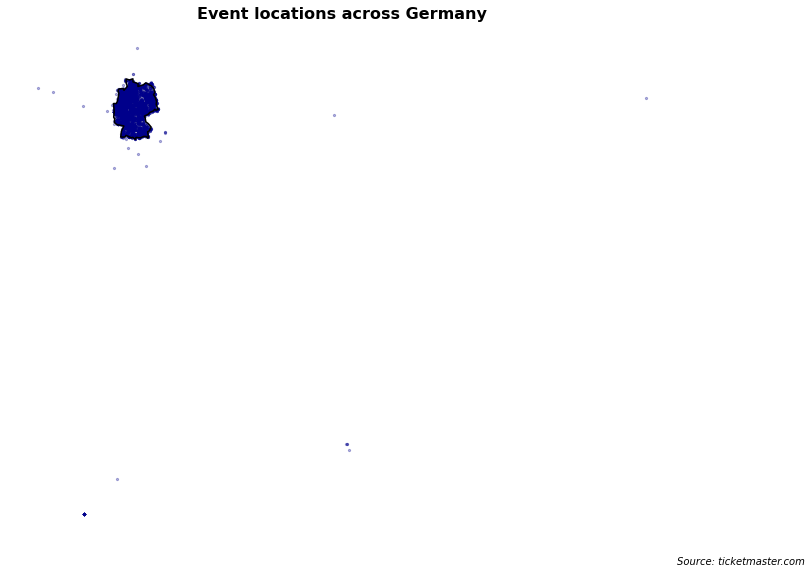

In [15]:
# call plotting function without specifiying the extreme points
plot_venues(
    venues_df=venues_DE,
    country='Germany'
)

<div class="task">
    <ol start=11>
        <li>You will find that some coordinates lie way beyond the German borders and can be assumed to be faulty. Set coordinate values to <code>NA</code> where the value of <code>longitude</code> is outside the range (<code>5.866, 15.042</code>) or where the value of <code>latitude</code> is outside the range (<code>47.270, 55.059</code>) (these coordinate ranges have been derived from the extreme points of Germany as listed on Wikipedia (see <a href="https://en.wikipedia.org/wiki/Geography_of_Germany#Extreme_points">here</a>). For extreme points of other countries, see <a href="https://en.wikipedia.org/wiki/Lists_of_extreme_points#Sovereign_states">here</a>).</li>
        </ol>
</div>

4407 venues are not plotted due to missing coordinates.
89 venues are not plotted due to faulty coordinates.


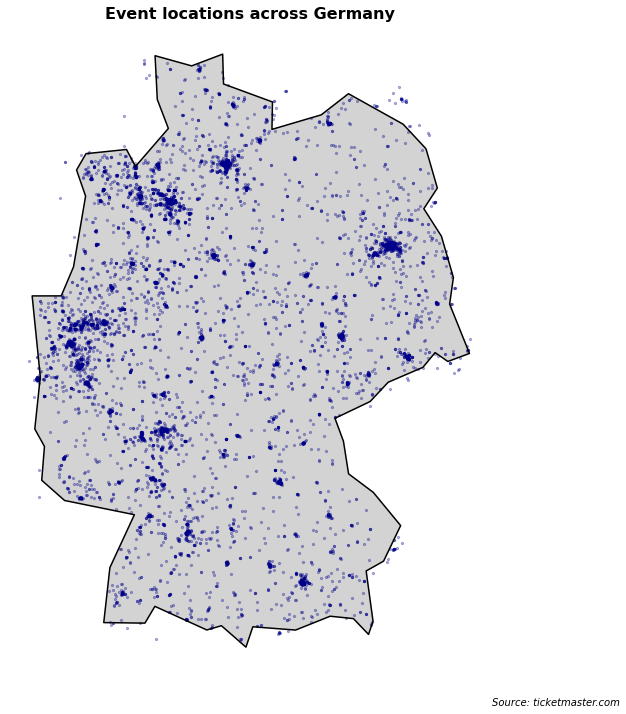

In [16]:
# call plotting function and pass extreme points
plot_venues(
    venues_df=venues_DE,
    country='Germany',
    lon_lat_ranges=dict(
        longitude = [5.866, 15.042], 
        latitude= [47.270, 55.059])
)

## 4 Event locations in other countries

<div class="task">
    <ol start=12>
        <li>Repeat exercises (9)–(11) for another European country of your choice. (Hint: Clean code pays off! If you have coded the exercises efficiently, only very few adaptions need to be made.)</li>
    </ol>
</div>

In [17]:
# call function to get venue data for the Netherlands (country_code='NL')
venues_NL = get_venues_in_country(country_code = 'NL')

Starting to retrieve venues in country "NL" from 5 pages...
Progress: [####################] 100%
Retrieved data for 2162 venues.


In [18]:
# show first 10 rows of data frame
venues_NL.head(10)

,name,city,postalCode,address,url,longitude,latitude
0,Gelredome,Arnhem,6841 HN,Batavierenweg 25,https://www.ticketmaster.nl/venue/gelredome-ar...,5.89304,51.96359
1,"Gashouder, Westergasfabriek",Amsterdam,1014 DD,Klonneplein 1,https://www.ticketmaster.nl/venue/transformato...,4.86984,52.38680
2,Het Concertgebouw Grote Zaal,Amsterdam,1071 LN,Concertgebouwplein 10,https://www.ticketmaster.nl/venue/het-concertg...,4.87830,52.35587
3,Diverse Locaties,Rotterdam,None,None,https://www.ticketmaster.nl/venue/diverse-loca...,4.47846,51.92285
4,Grand Theatre,Groningen,9711 LV,Grote Markt 35,https://www.ticketmaster.nl/venue/grand-theatr...,6.56866,53.21829
5,Mainstage,Den Bosch,5222 AA,Oude Engelenseweg 1,https://www.ticketmaster.nl/venue/mainstage-de...,5.28999,51.70140
6,"Brabanthallen, Den Bosch",Den Bosch,5222AA,Oude Engelenseweg 1,https://www.ticketmaster.nl/venue/brabanthalle...,5.28999,51.70140
7,Johan Cruijff ArenA,Amsterdam,1101 AX,ArenA Boulevard 1,https://www.ticketmaster.nl/venue/johan-cruijf...,4.94050,52.31373
8,Jan Cunenpark,Oss,None,Heschepad,https://www.ticketmaster.nl/venue/jan-cunenpar...,5.52426,51.76618
9,Annabel,Rotterdam,3013 AH,Schiestraat 18,https://www.ticketmaster.nl/venue/annabel-rott...,4.47610,51.92570


In [19]:
# print shape
venues_NL.shape

(2162, 7)

23 venues are not plotted due to missing coordinates.
18 venues are not plotted due to faulty coordinates.


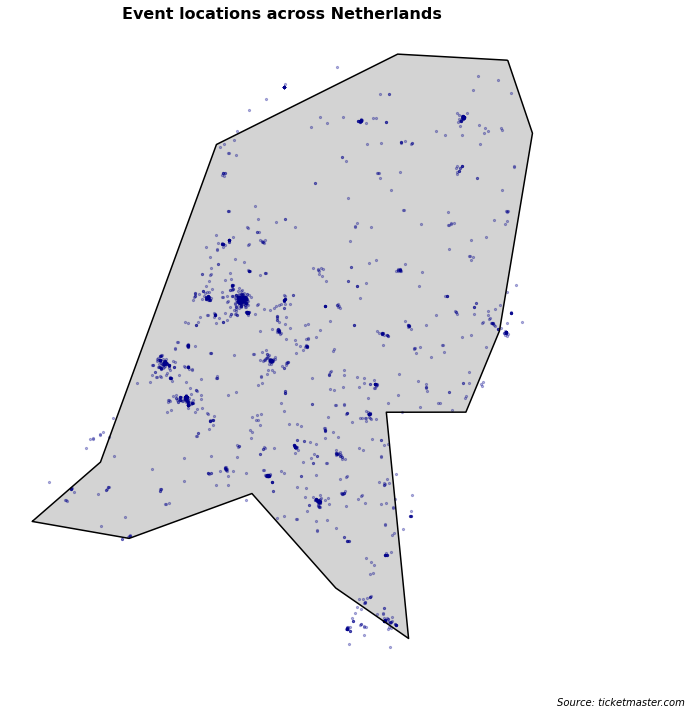

In [20]:
# plot venues in the Netherlands
plot_venues(
    venues_df=venues_NL,
    country='Netherlands',
    lon_lat_ranges=dict(
        latitude=[50.750166666666665, 53.553],
        longitude=[3.355, 7.223333333333334]
    )
)


<br>

***